# Multilevel modeling

In [100]:
# libraries
library(rstan)
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
library(brms)
library(loo)
library(haven)
library(sdazar)
library(data.table)
library(MASS)
library(bayesplot)
library(forcats)
library(ggplot2)
library(patchwork)
options(repr.plot.width = 5, repr.plot.height = 3)
source('Rutils/functions.R')

In [57]:
# load data

df = data.table(read_stata('../data/LA_uncertainty.dta'))

df = df[, .(ctry, year, gdp_pc, median)]
setnames(df, c('gdp_pc', 'median'), c('gdp', 'le'))
df = df[complete.cases(df)]

df[, le_log := scale(log(le), scale=FALSE)]
df[, gdp_log := scale(log(gdp), scale=FALSE)]

df[, year_c := scale(year, scale=FALSE)]

In [122]:
#head(df)

## Multilevel model

In [4]:
# how many countries
length(unique(df$ctry))

[1] 19

I centered the variables to facilitate estimation. 

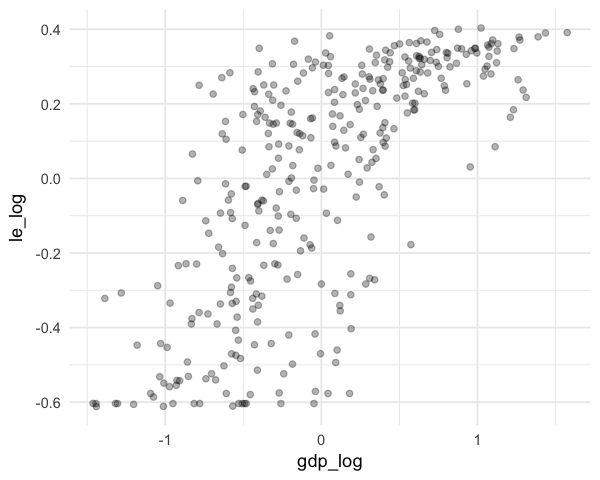

In [123]:
ggplot(df, aes(y=le_log, x=gdp_log)) + geom_point(alpha=0.3) + theme_minimal()

## Descriptives plots by country

### LE and GDP (logs)

Not always linear.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


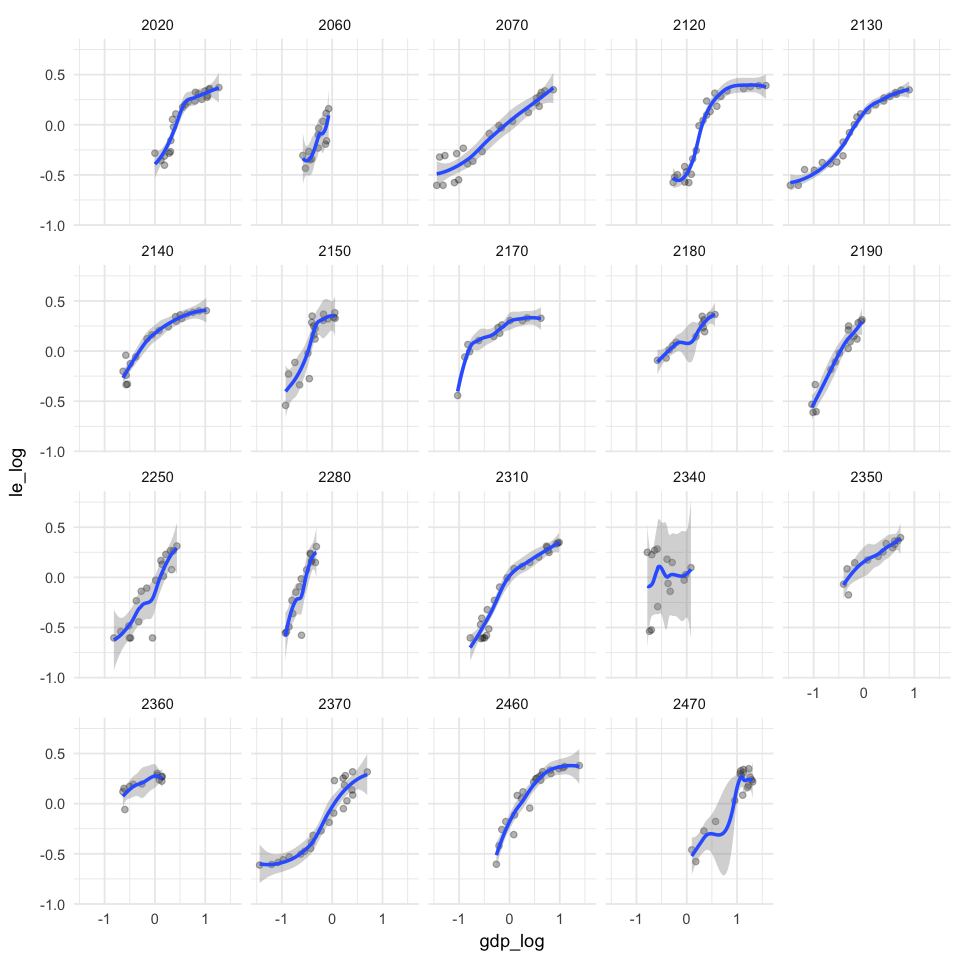

In [128]:
options(repr.plot.width = 8, repr.plot.height = 8)
p = ggplot(data = df, aes(x = gdp_log, y = le_log)) + geom_point(alpha=0.3) + geom_smooth() + theme_minimal()
p + facet_wrap(~ctry)

### LE and time

Far from linear!

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


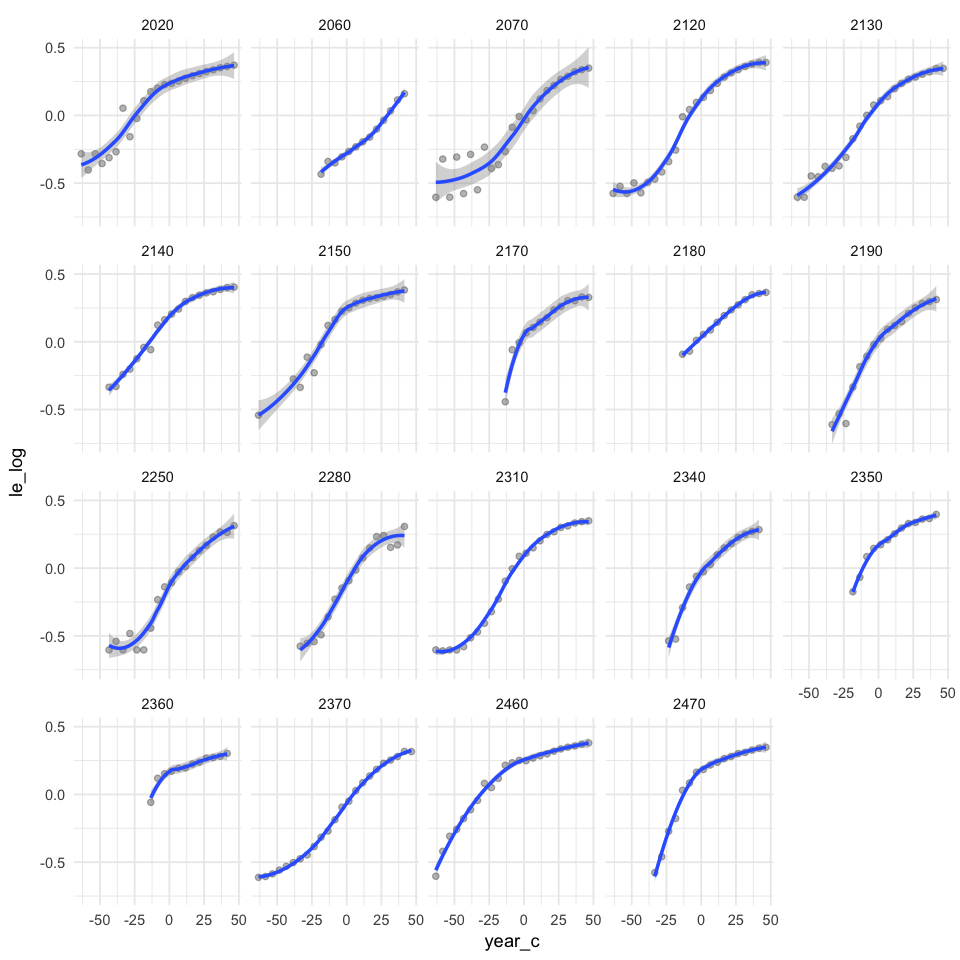

In [127]:
 options(repr.plot.width = 8, repr.plot.height = 8)
p = ggplot(data = df, aes(x = year_c, y = le_log)) + geom_point(alpha=0.3) + geom_smooth() + theme_minimal()
p + facet_wrap(~ctry)

# Models

### Only country and year intercept random effects

This is just to have a more basic model to compare with. 

In [68]:
m1 = brm(formula = le_log ~ year_c + gdp_log + (1|ctry) , 
    data = df)

Compiling the C++ model
Start sampling


In [70]:
summary(m1)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: le_log ~ year_c + gdp_log + (1 | ctry) 
   Data: df (Number of observations: 343) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~ctry (Number of levels: 19) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.11      0.02     0.07     0.15        623 1.00

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept    -0.00      0.02    -0.05     0.05        564 1.01
year_c        0.01      0.00     0.01     0.01       1253 1.00
gdp_log       0.07      0.02     0.02     0.11       1149 1.00

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     0.10      0.00     0.09     0.11       2591 1.00

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a crud

### Country and Time-varying coefficients (similar to Oeppen)

Both year and gdp effects vary by country. 

In [119]:
m2 = brm(formula = le_log ~ year_c + gdp_log + (year_c + gdp_log | ctry), 
    data = df)

Compiling the C++ model
Start sampling


In [129]:
summary(m2)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: le_log ~ year_c + gdp_log + (year_c + gdp_log | ctry) 
   Data: df (Number of observations: 343) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~ctry (Number of levels: 19) 
                       Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)              0.12      0.03     0.08     0.19       1479 1.00
sd(year_c)                 0.00      0.00     0.00     0.00       1697 1.00
sd(gdp_log)                0.10      0.03     0.04     0.18        993 1.01
cor(Intercept,year_c)     -0.30      0.26    -0.76     0.25       2280 1.00
cor(Intercept,gdp_log)    -0.48      0.29    -0.90     0.20       2671 1.00
cor(year_c,gdp_log)       -0.37      0.32    -0.83     0.38       2055 1.00

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Interce

### Comparing models

In [ ]:
l1 = LOO(m1)
l2 = LOO(m2)

In [132]:
compare(l1, l2)

elpd_diff        se 
     40.4       9.9 

Model 2 is better.

### Plotting predictions

Predicted values using all random effectsm from model 2! GOF is not good (only linear trend). The random effects correct overfitting by shrinking extreme values towards the mean. 

In [145]:
pred = cbind(df[, .(ctry, year_c, gdp_log, le_log)], predict(m2))
setnames(pred, c('Estimate', '2.5%ile', '97.5%ile'), c('m', 'lo', 'hi'))

In [146]:
countries = unique(pred$ctry)

In [148]:
for (i in 1:length(countries)) {
    assign(paste0('plot', i), 
           ggplot(pred[ctry==countries[i]], aes(x=year_c, y=le_log)) + 
           geom_line(aes(y=m), color='#2b8cbe', size = 0.4)  +
           geom_ribbon(aes(ymin = lo, ymax = hi), fill = '#a6bddb', alpha=0.2)  + 
           geom_point(size=1, color='#e34a33', alpha=0.4) +
           labs(title=paste0('Country ',countries[i])) + 
           ylim(-0.9, 0.7) + 
           xlim(-64, 47) + theme_minimal()
       )

}

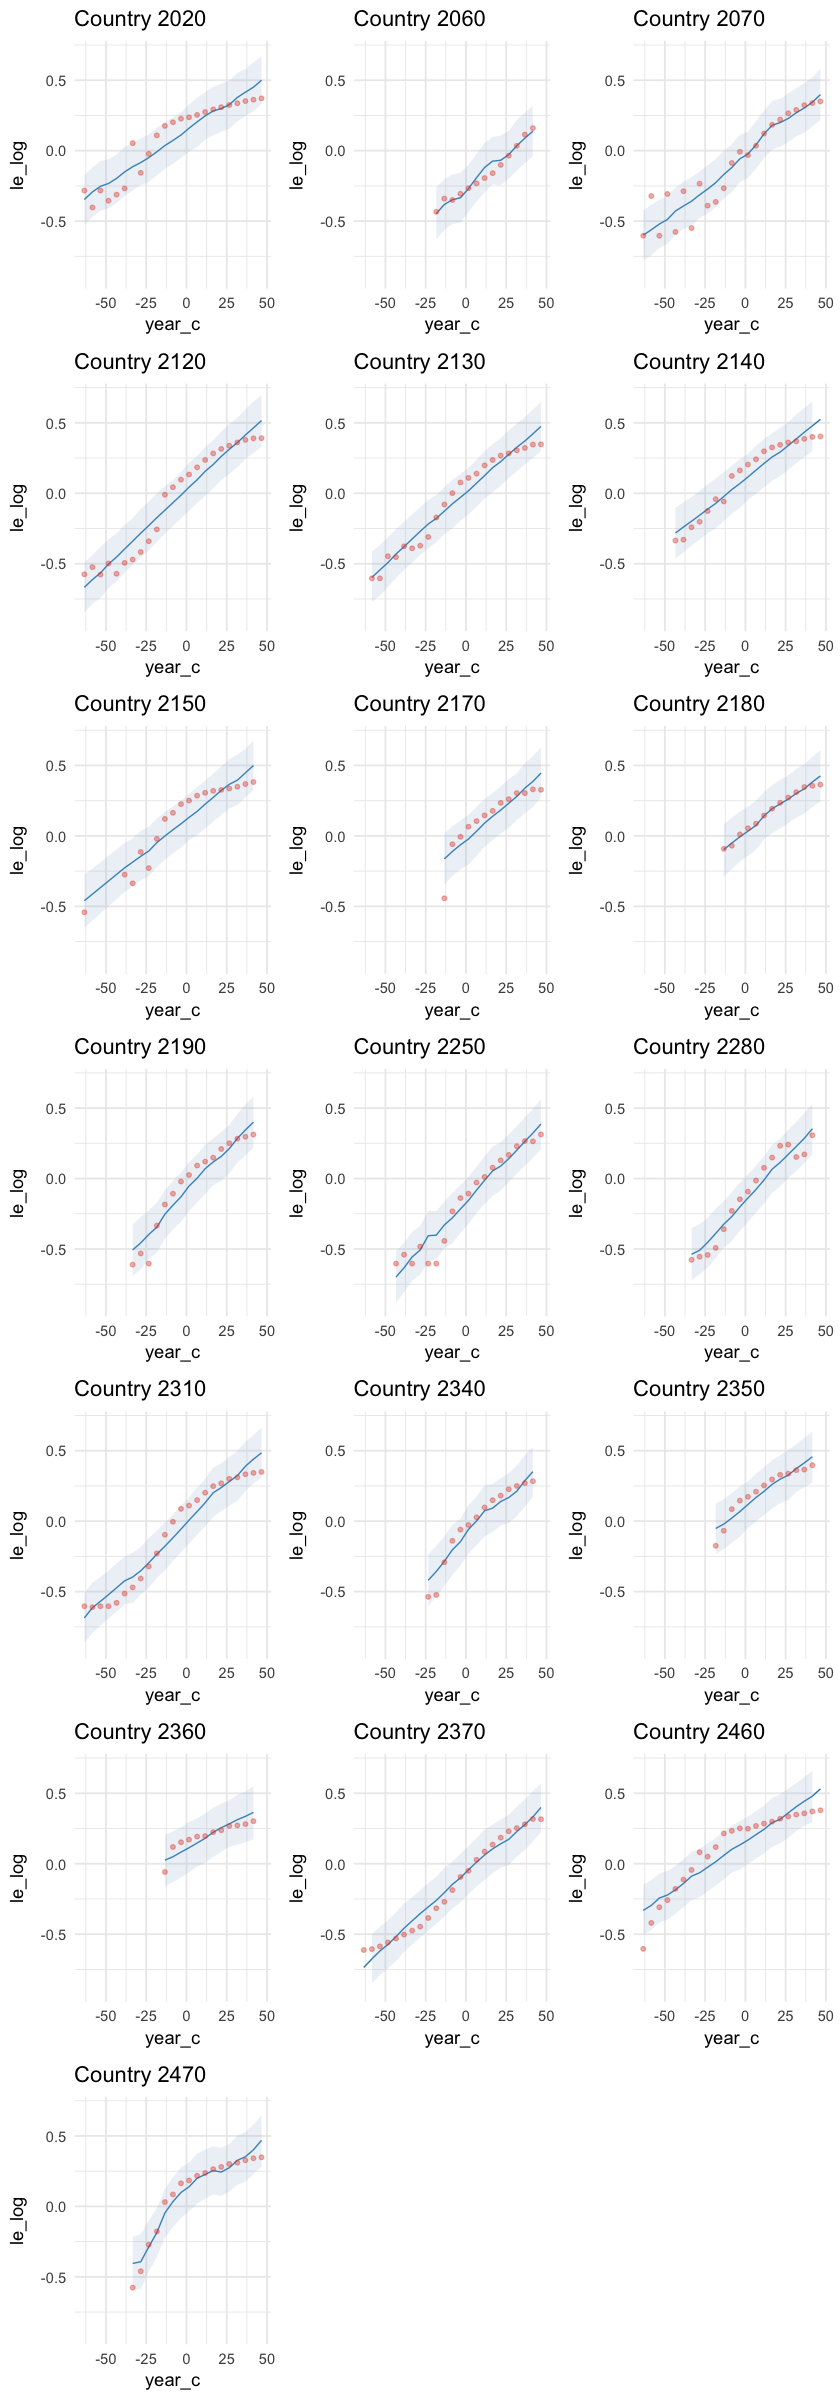

In [149]:
options(repr.plot.width = 7, repr.plot.height = 20)
eval(parse(text=paste0(paste0('plot', 1:length(countries), collapse='+'), '+plot_layout(ncol = 3)')))

# Random effects (Model 2)

In [151]:
re = ranef(m2) # get random effects

In [152]:
re_year = re$ctry[, c(1,3,4), 1]
re_year = data.table(year= rownames(re_year), re_year)
setnames(re_year, names(re_year), c('country', 'm', 'lo', 'hi'))

In [153]:
setkey(re_year, m)

re_year[, country := as_factor(country)]

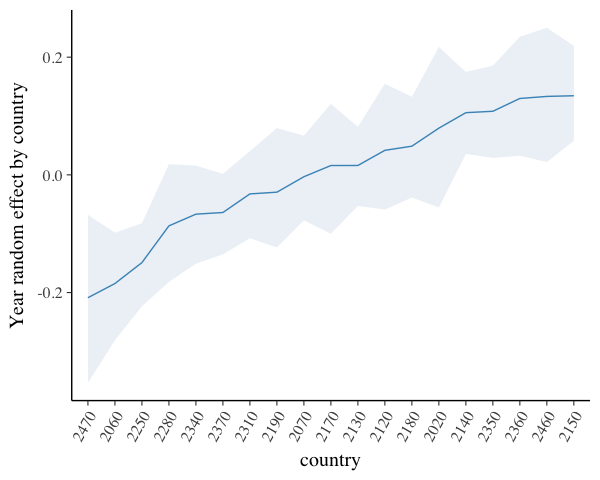

In [154]:
options(repr.plot.width = 5, repr.plot.height = 4)
ggplot(re_year, aes(x=country, y=m)) + 
geom_line(color='#2b8cbe', size = 0.4, group=1) + 
   geom_ribbon(aes(ymin = lo, ymax = hi), fill = '#a6bddb', alpha=0.2, group=1) + 
   labs(y='Year random effect by country') + 
   theme(axis.text.x = element_text(angle = 60, hjust = 1))

In [155]:
re_gdp = re$ctry[, c(1,3,4), 2]
re_gdp  = data.table(country= rownames(re_gdp), re_gdp)
setnames(re_gdp, names(re_gdp), c('country', 'm', 'lo', 'hi'))

In [156]:
setkey(re_gdp, m)
re_gdp[, country := as_factor(country)]

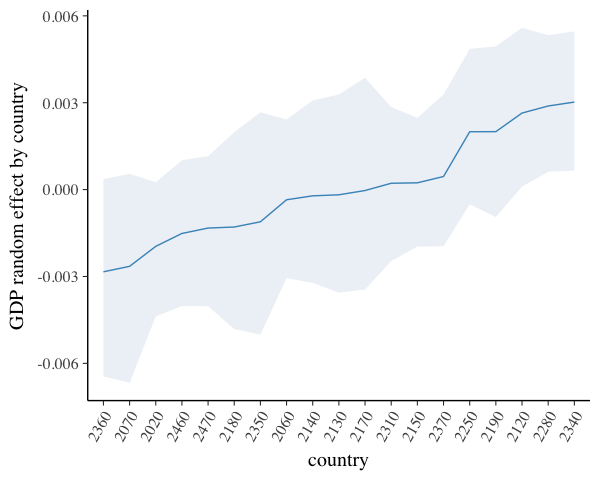

In [157]:
options(repr.plot.width = 5, repr.plot.height = 4)
ggplot(re_gdp, aes(x=country, y=m)) + 
geom_line(color='#2b8cbe', size = 0.4, group=1) + 
   geom_ribbon(aes(ymin = lo, ymax = hi), fill = '#a6bddb', alpha=0.2, group=1) + 
   labs(y='GDP random effect by country') + 
   theme(axis.text.x = element_text(angle = 60, hjust = 1))